In [7]:
import pyspark

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import NGram, Tokenizer
import pyspark.sql.functions as F

In [9]:
import boto3

In [10]:
s3_client=boto3.client('s3',region_name='eu-west-1')

In [11]:
s3_client.download_file('blossom-data-engs','all-us-stocks-tickers-company-info-logos.zip','all-us-stocks-tickers-company-info-logos.zip')

In [12]:
s3_client.download_file('blossom-data-engs','data-scientist-job-market-in-the-us.zip','data-scientist-job-market-in-the-us.zip')

In [13]:
#Create spar session
spark = SparkSession.builder.getOrCreate()

In [14]:
companies = spark.read.csv("companies.csv", header = True, inferSchema = True,escape='"', multiLine=True)

In [15]:
alldata = spark.read.csv("alldata.csv", header = True, inferSchema = True, escape='"', multiLine=True)

In [16]:
#joining 2 dataframes  (ta.join(tb, ta.description==tb.description)) or (ta.join(tb,ta['column']==tb[column]))
df_1 = companies.join(alldata, companies.description== alldata.description)

In [17]:
#filter out null rows of the description column in companies
companies = companies.filter(companies.description.isNotNull())

In [18]:
#filter out null rows of the description column in alldata
alldata = alldata.filter(alldata.description.isNotNull())


In [19]:
def method(comp, n):
    tokens = Tokenizer(inputCol='description', outputCol='tokens')
    companies = tokens.transform(comp)
    ngram = NGram(n=n, inputCol="tokens", outputCol="Ngram")
    companies = ngram.transform(companies)
    return companies

In [20]:
#Generating unigram from companies(description)
method(companies, 1)


DataFrame[ticker: string, company name: string, short name: string, industry: string, description: string, website: string, logo: string, ceo: string, exchange: string, market cap: decimal(12,0), sector: string, tag 1: string, tag 2: string, tag 3: string, tokens: array<string>, Ngram: array<string>]

In [21]:
#Generating bigrams from companies(description)
companies_1 = method(companies, 2)

In [38]:
def method(comp, n):
    tokens = Tokenizer(inputCol='position', outputCol='tokens')
    alldata = tokens.transform(comp)
    ngram = NGram(n=n, inputCol="tokens", outputCol="Ngram")
    alldata = ngram.transform(alldata)
    return alldata

In [39]:
#Generating unigram from alldata
method(alldata, 1)

DataFrame[position: string, company: string, description: string, reviews: int, location: string, tokens: array<string>, Ngram: array<string>]

In [51]:
#Generating bigramm from alldata
alldata_1 = method(alldata, 2)

In [52]:
companies_1.select('Ngram').limit(1).take(1)

[Row(Ngram=['agilent technologies', 'technologies inc', 'inc is', 'is engaged', 'engaged in', 'in life', 'life sciences,', 'sciences, diagnostics', 'diagnostics and', 'and applied', 'applied chemical', 'chemical markets.', 'markets. the', 'the company', 'company provides', 'provides application', 'application focused', 'focused solutions', 'solutions that', 'that include', 'include instruments,', 'instruments, software,', 'software, services', 'services and', 'and consumables', 'consumables for', 'for the', 'the entire', 'entire laboratory', 'laboratory workflow.'])]

In [53]:
newdf = companies_1.select(['Ngram' , 'industry']).select('industry' , F.explode('Ngram').alias('Ngram')).groupby(['Ngram' , 'industry']).count()

In [54]:
newdf.withColumnRenamed('count', 'frequency').show()

+--------------------+--------------------+---------+
|               Ngram|            industry|frequency|
+--------------------+--------------------+---------+
|    washington, d.c.|            Airlines|        1|
|    provider serving|Retail - Apparel ...|        1|
|plasma-based prod...|       Biotechnology|        1|
|   asbury automotive|               Autos|        1|
|interception, geo...|Communication Equ...|        1|
|         markets. it|Engineering & Con...|        1|
|             for the|               REITs|        4|
|               and a|Utilities - Regul...|        1|
|            the usa,|           Insurance|        1|
|       canadian gold|     Metals & Mining|        1|
|      namely aethlon|   Computer Hardware|        1|
|         provider of| Industrial Products|       11|
|      utilities, and|     Credit Services|        2|
|      for automotive|Homebuilding & Co...|        1|
| wireless networking|Communication Equ...|        1|
|           arthur j.| Broke

In [91]:
alldata_1 = alldata_1\
                .withColumn('city', F.split(alldata_1['location'], ',')[0])\
                .withColumn('state', F.split(alldata_1['location'], ',')[1])


In [92]:
newdf_1 = alldata_1.select(['Ngram' , 'city']).select('city' , F.explode('Ngram').alias('Ngram')).groupby(['Ngram' , 'city']).count()

In [93]:
newdf_2 =newdf_1.withColumnRenamed('count', 'frequency').show()

+--------------------+-------+---------+
|               Ngram|   city|frequency|
+--------------------+-------+---------+
|environmental sci...|Atlanta|        3|
| language processing|Atlanta|        2|
|        / artificial|Atlanta|        1|
|               - c++| Austin|        1|
|       quality staff| Austin|        1|
|    senior director,| Austin|        1|
| doctools architect,| Austin|        1|
|    project engineer|Boulder|       11|
|       lead software|Boulder|        1|
|   engineer (664143)|Boulder|        1|
|        & engagement| Boston|        1|
|scientist, transl...| Boston|        1|
| development manager| Boston|        3|
|   python experience| Boston|        1|
|            phd data| Boston|        1|
|    and quantitative|Chicago|        2|
|          us cities)|Chicago|        1|
|          central or|Chicago|        1|
|  senior consultant,|Chicago|        1|
|     biologics core,|Chicago|        1|
+--------------------+-------+---------+
only showing top

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pip install seaborn

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [94]:
import pandas as pd


In [99]:
df = newdf_1.toPandas()

In [100]:
df

,Ngram,city,count
0,environmental scientist,Atlanta,3
1,language processing,Atlanta,2
2,/ artificial,Atlanta,1
3,- c++,Austin,1
4,quality staff,Austin,1
...,...,...,...
14453,"i/ii, aav",Richmond,1
14454,liaison -,San Francisco,1
14455,"machine learning,",Sunnyvale,2
14456,staff data,Sunnyvale,4


In [108]:
 df_1 = df.groupby('Ngram').get_group('data scientist')

In [109]:
df_1

,Ngram,city,count
323,data scientist,San Carlos,6
692,data scientist,South San Francisco,13
1178,data scientist,Secaucus,1
1201,data scientist,San Ramon,2
1401,data scientist,Rahway,1
1463,data scientist,Washington,56
1598,data scientist,Chicago,80
2436,data scientist,Port Washington,1
2671,data scientist,Richmond,2
2702,data scientist,Jersey City,9


In [110]:
Final = df_1[df_1['city'].isin(['New York', 'Atlanta']) ]

In [111]:
Final

,Ngram,city,count
8239,data scientist,New York,243
13697,data scientist,Atlanta,50


Text(0.5, 1.0, 'Data Science Jobs In Selected Cities ')

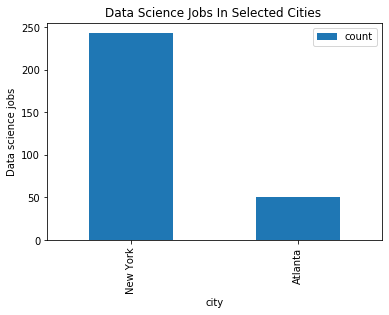

In [126]:
Final.plot.bar(x = 'city', y = 'count')
plt.ylabel('Data science jobs')
plt.title('Data Science Jobs In Selected Cities ')